In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import *
from sklearn.datasets import fetch_california_housing

In [2]:
### UTILITY FUNCTION FOR FEATURES PERMUTATION IMPORTANCE ###

def permut_features_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    seed=None, columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if seed is not None:
        np.random.seed(seed)
    
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
        
    error = loss_fun(model, X, y)
    features_imp = {}
    std_features_imp = {}     
        
    for col in np.arange(X.shape[-1]):
        
        _importance = []
        for _ in np.arange(n_repeats):
            
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            _importance.append(loss_fun(model, _X, y) - error)
                
        features_imp[columns_name[col]] = np.mean(_importance)
        std_features_imp[columns_name[col]] = np.std(_importance)
                
    return features_imp, std_features_imp

In [3]:
### UTILITY FUNCTION FOR SAMPLES PERMUTATION IMPORTANCE ###

def permut_sample_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    alpha=None, seed=None, columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if alpha is not None:
        assert alpha > 0 and alpha < 1
        
    if seed is not None:
        np.random.seed(seed)
        
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
    
    dist_error = loss_fun(model, X, y, normalize=False)
    sample_imp = {}
    
    for col in np.arange(X.shape[-1]):
        
        _importance = []
        for _ in np.arange(n_repeats):
        
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            dist_error_perm = loss_fun(model, _X, y, normalize=False)
            _importance.append(dist_error_perm - dist_error)
        
        if alpha is None:
            sample_imp[columns_name[col]] = np.quantile(
                np.asarray(_importance), 
                q = 0.5, axis = 0)
        else:
            sample_imp[columns_name[col]] = np.quantile(
                np.asarray(_importance), 
                q = [alpha/2, 0.5, 1-alpha/2], axis = 0).T
            
    return sample_imp

In [4]:
### LOSS FUNCTIONS ###

def mse(model, X, true, normalize=True): 
    
    if normalize:
        return np.mean(np.square(true - model.predict(X)))
    else:
        return np.square(true - model.predict(X)) 


def crossentropy(model, X, true, normalize=True):
    
    def _entropy(true, pred): return -(true * np.log(pred))
    
    true = np.asarray(true)
    classes = np.unique(true)
    pred_proba = model.predict_proba(X)
    pred_proba = pred_proba.clip(1e-5, 1 - 1e-5)
    
    c_entropy = np.zeros_like(true, dtype='float64')
    for c,cls in enumerate(classes):
        true_cls = (true == cls).astype(int)
        c_entropy += _entropy(true_cls, pred_proba[:,c])
    
    if normalize:
        return c_entropy.mean()
    else:
        return c_entropy

# REGRESSION

In [5]:
### READ DATA AND FIT A SIMPLE MODEL ###

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

m = Ridge()
m.fit(X,y)

error = mse(m, X, y)
error

0.5243210214822183

In [6]:
### COMPUTE FEATURES PERMUTATION IMPORTANCE ###

feat_imp_diz = permut_features_importance(m, X, y, loss_fun=mse, n_repeats=100, 
                                          columns_name=X.columns, seed=42)
feat_imp_mean, feat_imp_std = feat_imp_diz

feat_imp_mean = pd.Series(feat_imp_mean)
feat_imp_std = pd.Series(feat_imp_std)

order = feat_imp_mean.sort_values(ascending=False).index
feat_imp_mean = feat_imp_mean[order]
feat_imp_std = feat_imp_std[order]

Text(0, 0.5, 'importance')

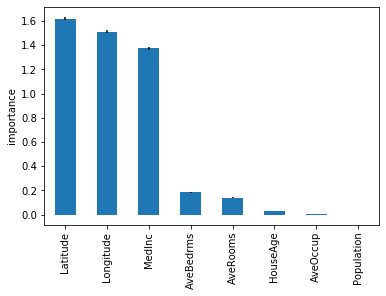

In [7]:
### PLOT FEATURES PERMUTATION IMPORTANCE ###

feat_imp_mean.plot.bar(yerr=feat_imp_std)
plt.ylabel('importance')

In [8]:
### COMPUTE SAMPLES PERMUTATION IMPORTANCE ###

imp_diz = permut_sample_importance(m, X, y, loss_fun=mse, alpha=None, n_repeats=100, 
                                   columns_name=X.columns, seed=42)

imp_df = pd.DataFrame({c : imp_diz[c].clip(*np.quantile(imp_diz[c], [0.05,0.95])) for c in imp_diz})
order = imp_df.median().sort_values().index
imp_df = imp_df[order]

imp_df.head()

,Population,AveOccup,AveBedrms,HouseAge,AveRooms,MedInc,Latitude,Longitude
0,0.002254,0.001285,-0.015174,0.074221,-0.111438,4.417535,1.305102,3.879119
1,0.004436,-0.001917,0.044434,0.030975,0.068576,2.656413,3.196202,1.368519
2,-0.000860,-0.000051,-0.004781,-0.011439,0.206165,1.967909,2.915569,0.817332
3,0.000914,0.000403,0.009356,0.103807,-0.015751,1.477602,1.820008,3.420144
4,0.004179,0.003802,0.031326,0.302469,-0.177004,0.435225,-0.259583,3.406667


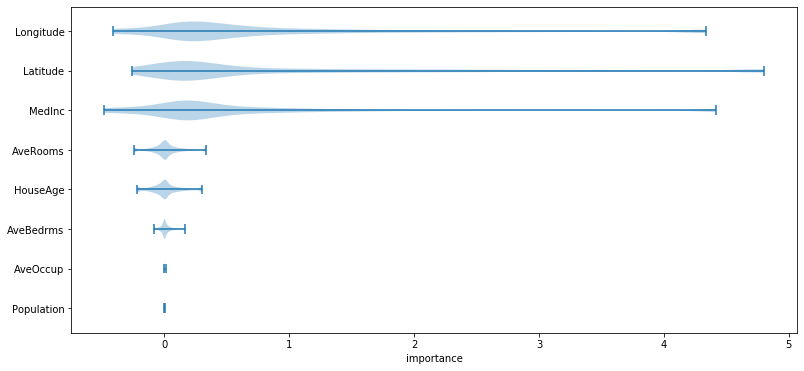

In [9]:
### PLOT SAMPLE PERMUTATION IMPORTANCE SCORES ###

plt.figure(figsize=(13,6))

plt.violinplot(dataset = imp_df.values, vert = False)
plt.yticks(range(1,imp_df.shape[1]+1), imp_df.columns); plt.xlabel('importance')
np.set_printoptions(False)

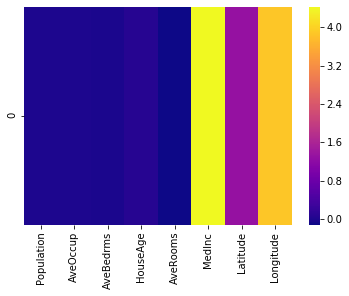

In [10]:
### PLOT IMPORTANCE FOR SINGLE OBSEVATION ###

sns.heatmap(imp_df.iloc[[0]], cmap = 'plasma')

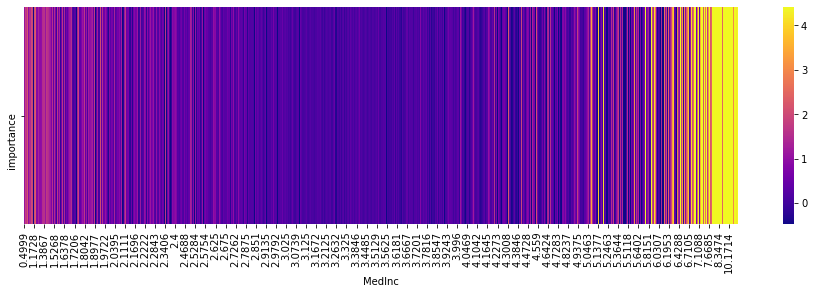

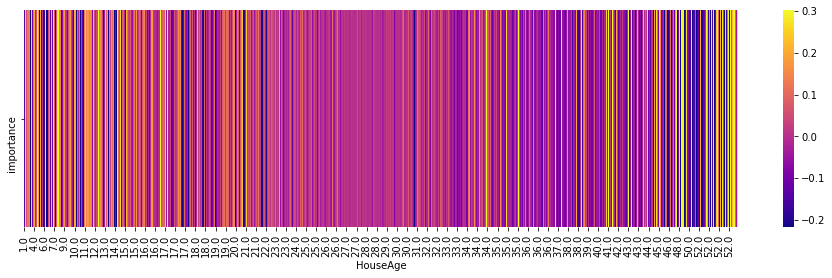

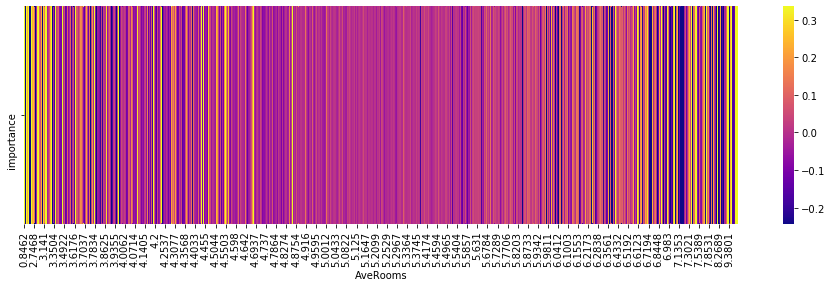

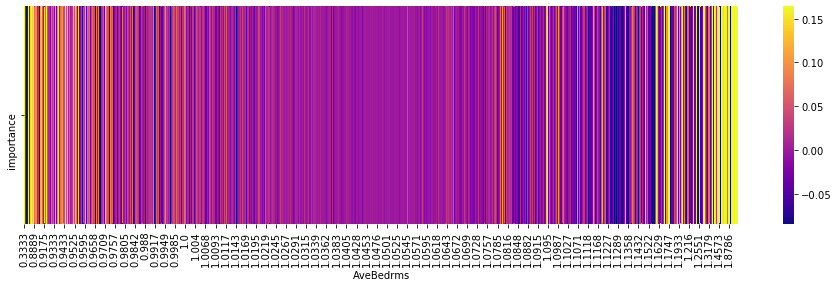

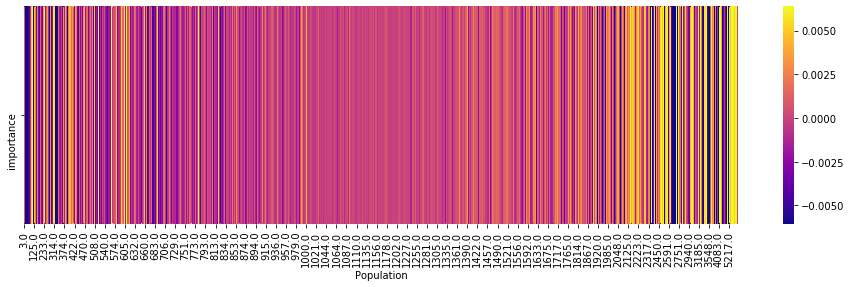

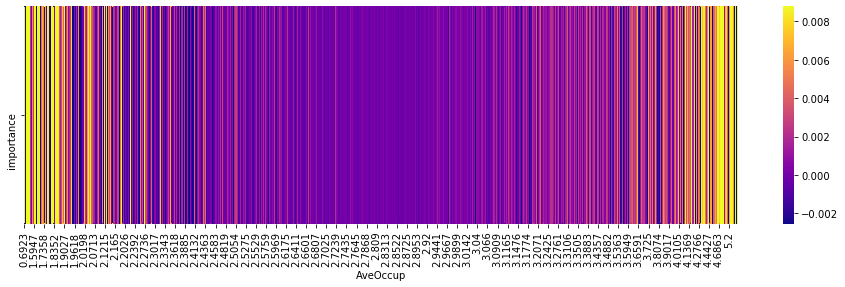

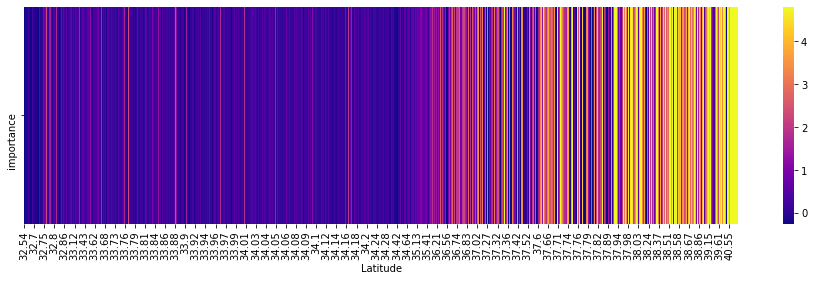

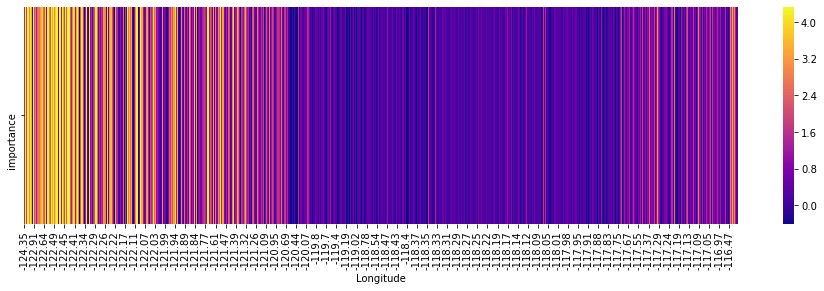

In [11]:
### PLOT IMPORTANCE FOR OBSEVATIONS IN EACH COLUMNS ###

for column in X:

    _df = pd.DataFrame({
        column: X[column].round(4), 
        'importance': imp_df[column]
    }).set_index(column).sort_index()

    plt.figure(figsize=(16,4))
    sns.heatmap(_df.T, cmap='plasma')
    plt.show()

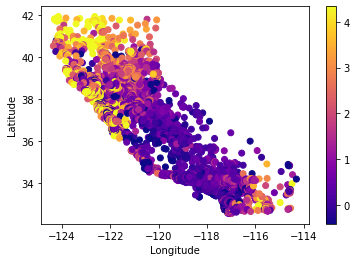

In [12]:
### PLOT IMPORTANCE FOR OBSEVATIONS WITH INTERACTIONS BETWEEN COLUMNS ###

plt.scatter(X['Longitude'], X['Latitude'], c=imp_df['Longitude'], cmap='plasma')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.colorbar()

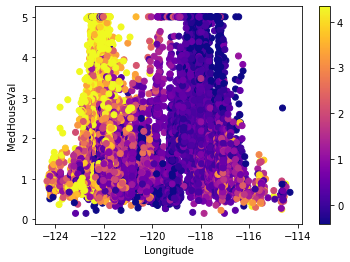

In [13]:
### PLOT IMPORTANCE FOR OBSEVATIONS WITH INTERACTIONS BETWEEN COLUMNS ###

plt.scatter(X['Longitude'], y, c=imp_df['Longitude'], cmap='plasma')
plt.xlabel('Longitude'); plt.ylabel(y.name)
plt.colorbar()

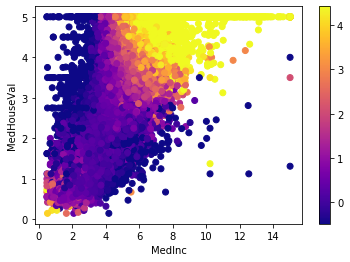

In [14]:
### PLOT IMPORTANCE FOR OBSEVATIONS WITH INTERACTIONS BETWEEN COLUMNS ###

plt.scatter(X['MedInc'], y, c=imp_df['MedInc'], cmap='plasma')
plt.xlabel('MedInc'); plt.ylabel(y.name)
plt.colorbar()

# CLASSIFICATION

In [15]:
### READ DATA AND FIT A SIMPLE MODEL ###

X = pd.read_csv('winequality-red.csv')
y = X['quality']
X.drop('quality', inplace=True, axis=1)

m = LogisticRegression(max_iter=10_000)
m.fit(X,y)

error = crossentropy(m, X, y)
error

0.9361864503316772

In [16]:
### COMPUTE FEATURES PERMUTATION IMPORTANCE ###

feat_imp_diz = permut_features_importance(m, X, y, loss_fun=crossentropy, n_repeats=100, 
                                          columns_name=X.columns, seed=42)
feat_imp_mean, feat_imp_std = feat_imp_diz

feat_imp_mean = pd.Series(feat_imp_mean)
feat_imp_std = pd.Series(feat_imp_std)

order = feat_imp_mean.sort_values(ascending=False).index
feat_imp_mean = feat_imp_mean[order]
feat_imp_std = feat_imp_std[order]

Text(0, 0.5, 'importance')

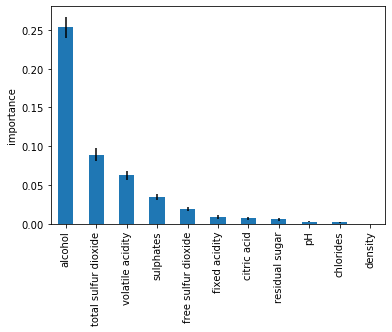

In [17]:
### PLOT FEATURES PERMUTATION IMPORTANCE ###

feat_imp_mean.plot.bar(yerr=feat_imp_std)
plt.ylabel('importance')

In [18]:
### COMPUTE SAMPLES PERMUTATION IMPORTANCE ###

imp_diz = permut_sample_importance(m, X, y, loss_fun=crossentropy, alpha=None, n_repeats=100, 
                                   columns_name=X.columns, seed=42)

imp_df = pd.DataFrame({c : imp_diz[c].clip(*np.quantile(imp_diz[c], [0.05,0.95])) for c in imp_diz})
order = imp_df.median().sort_values().index
imp_df = imp_df[order]

imp_df.head()

,density,citric acid,residual sugar,free sulfur dioxide,pH,chlorides,fixed acidity,sulphates,volatile acidity,total sulfur dioxide,alcohol
0,-1.280875e-05,-0.050405,0.005729,0.021887,-0.014277,-0.000571,0.012349,0.028048,0.111837,0.019352,0.243161
1,7.239760e-07,-0.051883,-0.004867,-0.051678,0.004964,0.005510,0.004493,-0.024915,0.278441,0.206369,0.049844
2,-4.331941e-06,-0.050845,-0.000949,-0.010759,0.002223,0.003941,0.006243,-0.011478,0.189318,0.043415,0.071400
3,4.152386e-05,-0.116111,-0.001077,0.035219,-0.004732,0.003561,0.146750,-0.023101,0.314697,-0.122693,-0.069668
4,-1.164434e-05,-0.065803,0.006892,0.007825,-0.014608,-0.001141,0.011188,0.019463,0.115361,0.006318,0.243161


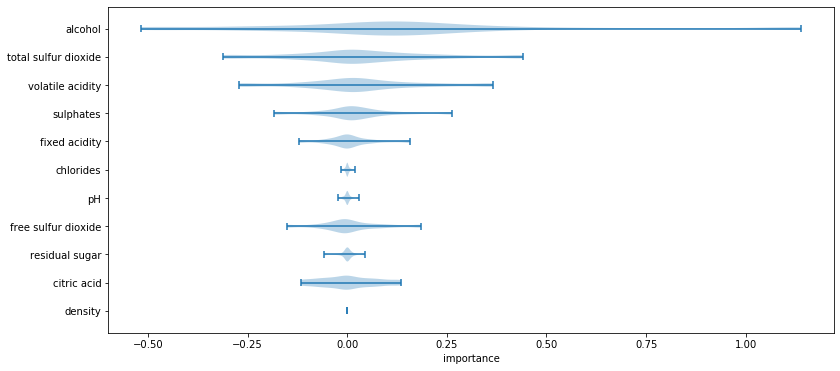

In [19]:
### PLOT SAMPLE PERMUTATION IMPORTANCE SCORES ###

plt.figure(figsize=(13,6))

plt.violinplot(dataset = imp_df.values, vert = False)
plt.yticks(range(1,imp_df.shape[1]+1), imp_df.columns); plt.xlabel('importance')
np.set_printoptions(False)

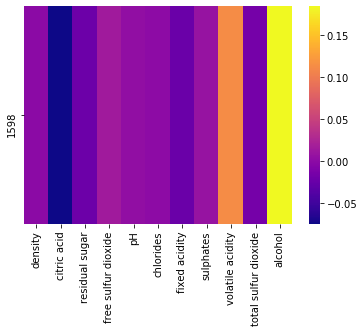

In [20]:
### PLOT IMPORTANCE FOR SINGLE OBSEVATION ###

sns.heatmap(imp_df.iloc[[-1]], cmap = 'plasma')

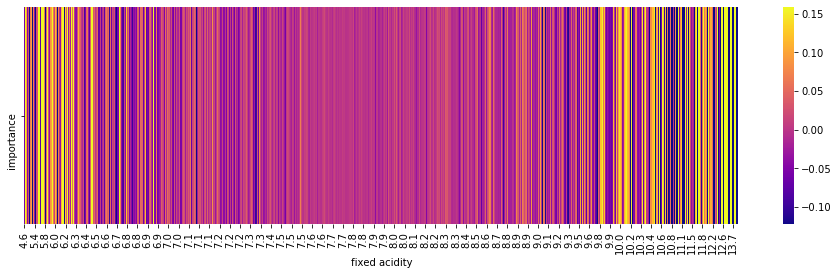

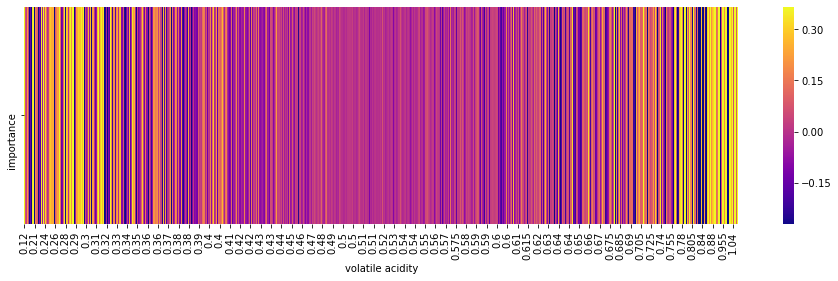

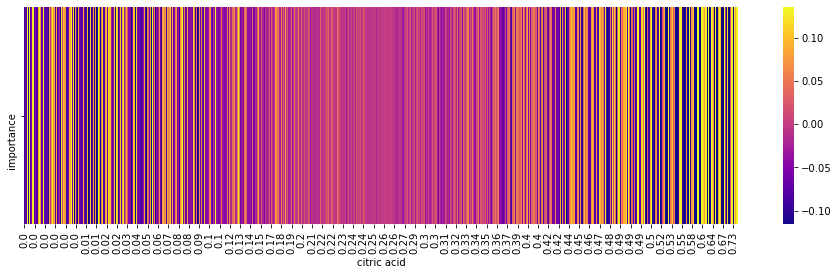

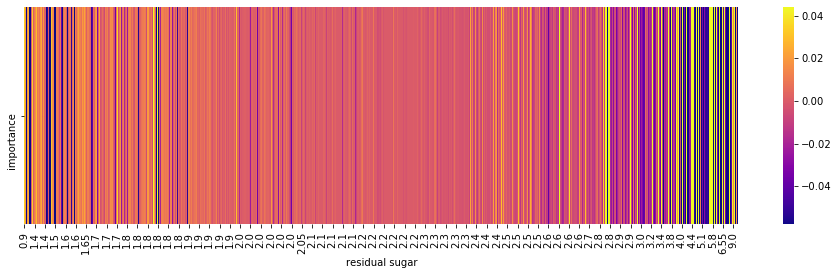

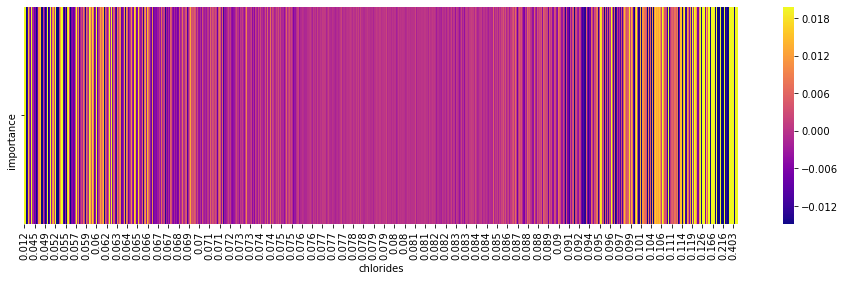

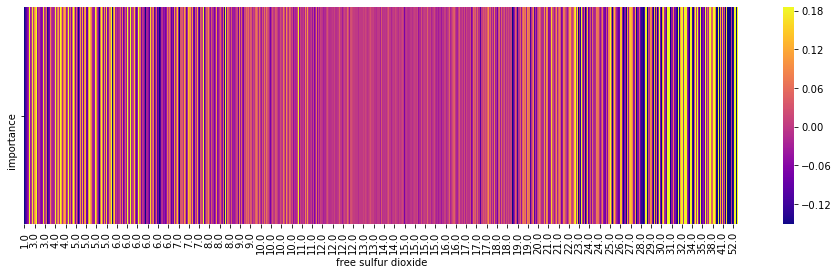

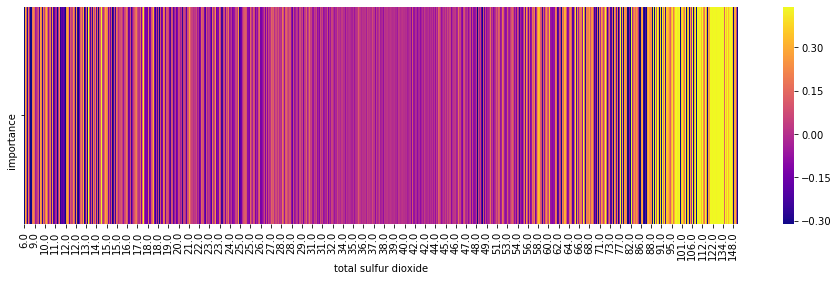

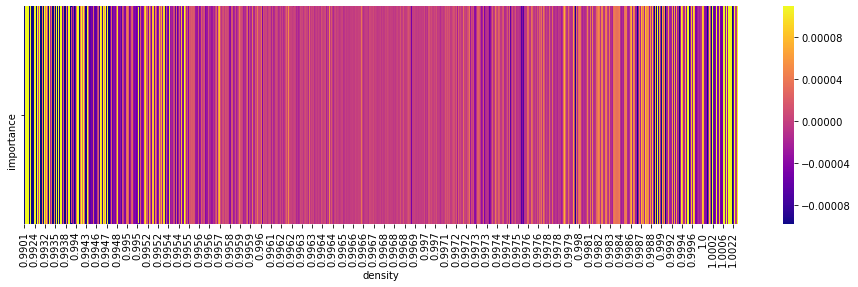

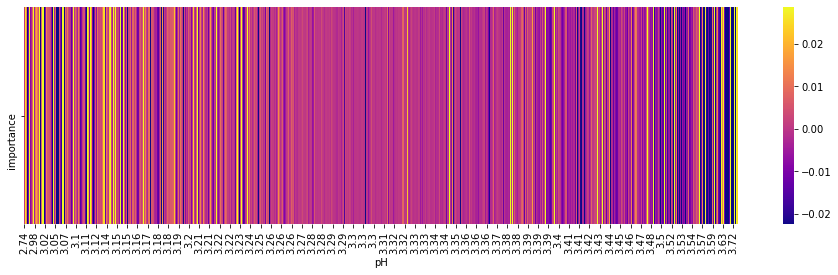

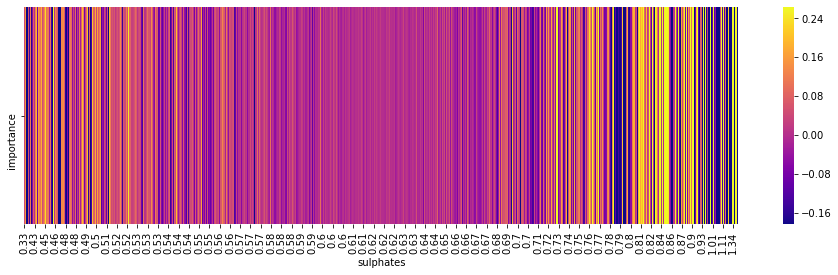

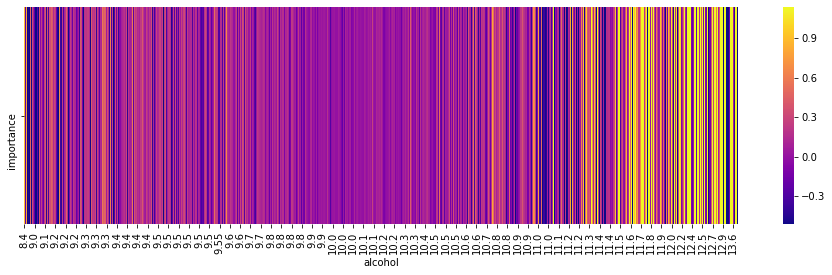

In [21]:
### PLOT IMPORTANCE FOR OBSEVATIONS IN EACH COLUMNS ###

for column in X:

    _df = pd.DataFrame({
        column: X[column].round(4), 
        'importance': imp_df[column]
    }).set_index(column).sort_index()

    plt.figure(figsize=(16,4))
    sns.heatmap(_df.T, cmap='plasma')
    plt.show()

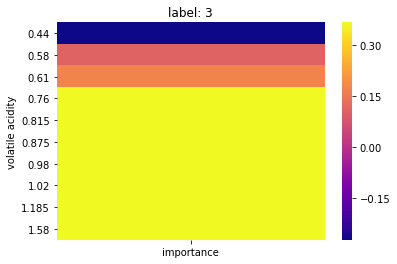

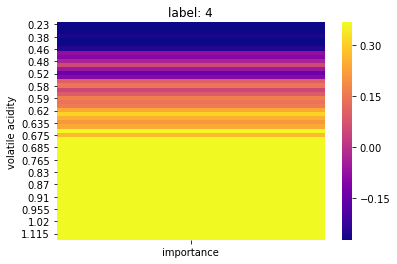

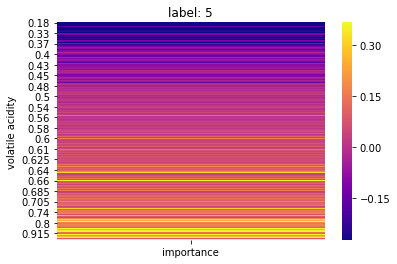

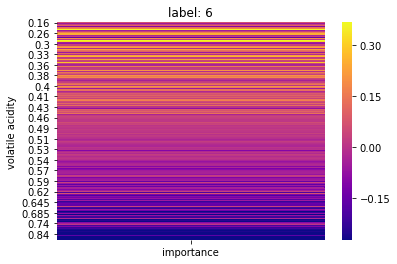

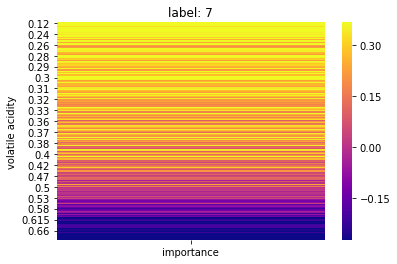

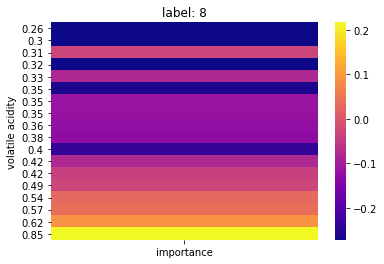

In [22]:
### PLOT IMPORTANCE FOR OBSEVATIONS WITH INTERACTIONS BETWEEN FEATURES AND LABELS ###

column = 'volatile acidity'

for lab in np.unique(y):
    
    _df = pd.DataFrame({
        column: X[column][y == lab].round(4), 
        'importance': imp_df[column][y == lab]
    }).set_index(column).sort_index()
    
    sns.heatmap(_df, cmap='plasma')
    plt.title(f"label: {lab}"); plt.show()